In [19]:
!pip install torch transformers seqeval tqdm matplotlib scikit-learn


You should consider upgrading via the 'D:\Visual Studio\NLP1\vimedner_env\Scripts\python.exe -m pip install --upgrade pip' command.


In [20]:
import os
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.optim import AdamW
from transformers import AutoTokenizer, AutoModel, AutoConfig, get_linear_schedule_with_warmup
from torch.utils.data import Dataset, DataLoader
from seqeval.metrics import classification_report, f1_score, precision_score, recall_score
from typing import List, Dict, Tuple, Optional, Union


In [28]:
class Config:
    def __init__(self):
        self.model_name = "vinai/phobert-base"
        self.num_labels = 11
        self.dropout = 0.3
        self.max_length = 128
        self.learning_rate = 2e-5
        self.batch_size = 1
        self.num_epochs = 15
        self.warmup_steps = 200
        self.weight_decay = 0.05
        self.save_steps = 500
        self.eval_steps = 250
        self.logging_steps = 50
        self.gradient_accumulation_steps = 4
        self.output_dir = "models/best_model"

config = Config()


In [22]:
class NERDataset(Dataset):
    def __init__(self, file_path: str, tokenizer, max_length: int = 128):
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.sentences, self.tags = self.read_conll_file(file_path)
        
    def read_conll_file(self, file_path: str):
        with open(file_path, 'r', encoding='utf-8') as f:
            lines = f.readlines()
            
        sentences = []
        current_sentence = []
        current_tags = []
        
        for line in lines:
            line = line.strip()
            if not line:  # Kết thúc câu
                if current_sentence:
                    sentences.append((current_sentence, current_tags))
                    current_sentence = []
                    current_tags = []
            else:
                parts = line.split()
                if len(parts) >= 2:
                    word = parts[0]
                    tag = parts[-1]
                    current_sentence.append(word)
                    current_tags.append(tag)
        
        # Thêm câu cuối cùng nếu có
        if current_sentence:
            sentences.append((current_sentence, current_tags))
            
        # Tách sentences và tags
        all_sentences = [s[0] for s in sentences]
        all_tags = [s[1] for s in sentences]
        
        return all_sentences, all_tags
        
    def __len__(self):
        return len(self.sentences)
    
    def __getitem__(self, idx):
        sentence = self.sentences[idx]
        word_labels = self.tags[idx]
        
        # Tokenize
        encoding = self.tokenizer(
            sentence,
            is_split_into_words=True,
            max_length=self.max_length,
            truncation=True,
            padding='max_length',
            return_tensors='pt'
        )
        
        input_ids = encoding['input_ids'].squeeze()
        attention_mask = encoding['attention_mask'].squeeze()
        
        # Gán nhãn cho token (thủ công, không dùng word_ids())
        label_ids = []
        word_idx = 0  # Chỉ số từ gốc
        for token_id in input_ids:
            if token_id == self.tokenizer.pad_token_id:
                label_ids.append(-100)
            else:
                # Gán nhãn cho token đầu tiên, subword sau = -100
                if word_idx < len(word_labels):
                    label_ids.append(self.label2id.get(word_labels[word_idx], -100))
                    word_idx += 1
                else:
                    label_ids.append(-100)
        
        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': torch.tensor(label_ids, dtype=torch.long)
        }


In [23]:
class PhoBERTForNER(nn.Module):
    def __init__(self, model_name: str, num_labels: int, dropout: float = 0.1):
        super().__init__()
        self.num_labels = num_labels
        
        # Load pre-trained PhoBERT
        self.phobert = AutoModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(dropout)
        
        # Classifier
        self.classifier = nn.Linear(self.phobert.config.hidden_size, num_labels)
        
        # Khởi tạo trọng số
        self.init_weights()
        
    def forward(self, input_ids, attention_mask=None, labels=None):
        outputs = self.phobert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=True
        )
        
        sequence_output = outputs.last_hidden_state
        sequence_output = self.dropout(sequence_output)
        logits = self.classifier(sequence_output)
        
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss(ignore_index=-100)
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            
        return {
            'loss': loss,
            'logits': logits
        }
    
    def init_weights(self):
        nn.init.xavier_uniform_(self.classifier.weight)
        if self.classifier.bias is not None:
            nn.init.constant_(self.classifier.bias, 0)

In [24]:
def load_data(tokenizer, train_file: str, val_file: str, test_file: str, batch_size: int = 4):
    train_dataset = NERDataset(train_file, tokenizer)
    val_dataset = NERDataset(val_file, tokenizer)
    test_dataset = NERDataset(test_file, tokenizer)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    label2id = {label: idx for idx, label in enumerate(sorted(set([tag for tags in train_dataset.tags for tag in tags])))}
    id2label = {v: k for k, v in label2id.items()}
    
    for dataset in [train_dataset, val_dataset, test_dataset]:
        dataset.label2id = label2id
    
    return train_loader, val_loader, test_loader, label2id, id2label

In [25]:
def evaluate(model, data_loader, device, id2label):
    model.eval()
    eval_loss = 0.0
    predictions = []
    true_labels = []
    
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            
            eval_loss += outputs['loss'].item() if outputs['loss'] is not None else 0
            logits = outputs['logits']
            preds = torch.argmax(logits, dim=-1)
            preds = preds.detach().cpu().numpy()
            label_ids = labels.detach().cpu().numpy()
            
            for i in range(len(preds)):
                pred = [id2label[p] for p, l in zip(preds[i], label_ids[i]) if l != -100]
                true = [id2label[l] for p, l in zip(preds[i], label_ids[i]) if l != -100]
                
                predictions.append(pred)
                true_labels.append(true)
    
    results = {
        'loss': eval_loss / len(data_loader),
        'f1': f1_score(true_labels, predictions),
        'precision': precision_score(true_labels, predictions),
        'recall': recall_score(true_labels, predictions),
        'report': classification_report(true_labels, predictions)
    }
    
    return results

In [26]:
def predict_ner(text: str, model, tokenizer, id2label: Dict[int, str], max_length: int = 128):
    words = text.split()
    
    encoding = tokenizer(
        words,
        is_split_into_words=True,
        max_length=max_length,
        truncation=True,
        padding='max_length',
        return_tensors='pt'
    ).to(device)
    
    input_ids = encoding['input_ids']
    attention_mask = encoding['attention_mask']
    
    model.eval()
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    
    predictions = torch.argmax(outputs['logits'], dim=-1)[0].cpu().numpy()
    
    # Gán nhãn cho token đầu tiên mỗi từ
    word_predictions = []
    word_idx = 0
    for token_id, pred_idx in zip(input_ids[0], predictions):
        if token_id == tokenizer.pad_token_id:
            continue
        if word_idx < len(words):
            word_predictions.append((words[word_idx], id2label.get(pred_idx, 'O')))
            word_idx += 1
    
    return word_predictions


In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

tokenizer = AutoTokenizer.from_pretrained(config.model_name)  # Không dùng use_fast=True

train_loader, val_loader, test_loader, label2id, id2label = load_data(
    tokenizer=tokenizer,
    train_file="data/train.txt",
    val_file="data/dev.txt",
    test_file="data/test.txt",
    batch_size=config.batch_size
)

model = PhoBERTForNER(
    model_name=config.model_name,
    num_labels=len(label2id),
    dropout=config.dropout
).to(device)

if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs!")
    model = nn.DataParallel(model)

Using device: cuda


In [30]:
optimizer = AdamW(
    model.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)

# Lịch trình học tập
total_steps = len(train_loader) * config.num_epochs // config.gradient_accumulation_steps
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=config.warmup_steps,
    num_training_steps=total_steps
)

# Vòng lặp huấn luyện
best_f1 = 0
train_losses = []
val_losses = []
val_f1s = []

for epoch in range(config.num_epochs):
    # Huấn luyện
    model.train()
    epoch_loss = 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{config.num_epochs}")
    
    for step, batch in enumerate(progress_bar):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        
        loss = outputs['loss']
        loss = loss / config.gradient_accumulation_steps
        loss.backward()
        
        if (step + 1) % config.gradient_accumulation_steps == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
        
        epoch_loss += loss.item()
        progress_bar.set_postfix({'loss': loss.item() * config.gradient_accumulation_steps})
    
    # Đánh giá trên tập validation
    val_results = evaluate(model, val_loader, device, id2label)
    val_losses.append(val_results['loss'])
    val_f1s.append(val_results['f1'])
    
    # Lưu mô hình tốt nhất
    if val_results['f1'] > best_f1:
        best_f1 = val_results['f1']
        if not os.path.exists(config.output_dir):
            os.makedirs(config.output_dir)
        
        # Lưu mô hình
        model_to_save = model.module if hasattr(model, 'module') else model
        torch.save(model_to_save.state_dict(), os.path.join(config.output_dir, "pytorch_model.bin"))
        tokenizer.save_pretrained(config.output_dir)
        
        with open(os.path.join(config.output_dir, "config.json"), "w") as f:
            import json
            json.dump({"label2id": label2id, "id2label": id2label}, f)
    
    print(f"Epoch {epoch + 1}/{config.num_epochs}")
    print(f"Train Loss: {epoch_loss / len(train_loader):.4f}")
    print(f"Val Loss: {val_results['loss']:.4f}")
    print(f"Val F1: {val_results['f1']:.4f}")
    print(f"Val Precision: {val_results['precision']:.4f}")
    print(f"Val Recall: {val_results['recall']:.4f}")
    print("Classification Report:")
    print(val_results['report'])
    print("-" * 50)``

Epoch 1/15: 100%|██████████| 4573/4573 [06:35<00:00, 11.57it/s, loss=0.581] 


Epoch 1/15
Train Loss: 0.1723
Val Loss: 0.4883
Val F1: 0.3958
Val Precision: 0.4002
Val Recall: 0.3915
Classification Report:
                     precision    recall  f1-score   support

bien_phap_chan_doan       0.39      0.32      0.35       271
 bien_phap_dieu_tri       0.25      0.28      0.27       653
   nguyen_nhan_benh       0.06      0.02      0.03       259
           ten_benh       0.50      0.52      0.51      1798
   trieu_chung_benh       0.34      0.32      0.33       748

          micro avg       0.40      0.39      0.40      3729
          macro avg       0.31      0.30      0.30      3729
       weighted avg       0.39      0.39      0.39      3729

--------------------------------------------------


Epoch 2/15: 100%|██████████| 4573/4573 [06:36<00:00, 11.53it/s, loss=0.796]  


Epoch 2/15
Train Loss: 0.1126
Val Loss: 0.4541
Val F1: 0.4589
Val Precision: 0.4603
Val Recall: 0.4575
Classification Report:
                     precision    recall  f1-score   support

bien_phap_chan_doan       0.52      0.42      0.46       271
 bien_phap_dieu_tri       0.40      0.33      0.36       653
   nguyen_nhan_benh       0.09      0.15      0.11       259
           ten_benh       0.59      0.58      0.58      1798
   trieu_chung_benh       0.39      0.41      0.40       748

          micro avg       0.46      0.46      0.46      3729
          macro avg       0.40      0.38      0.38      3729
       weighted avg       0.48      0.46      0.47      3729

--------------------------------------------------


Epoch 3/15: 100%|██████████| 4573/4573 [06:33<00:00, 11.62it/s, loss=0.747]  


Epoch 3/15
Train Loss: 0.0863
Val Loss: 0.4452
Val F1: 0.4780
Val Precision: 0.4823
Val Recall: 0.4739
Classification Report:
                     precision    recall  f1-score   support

bien_phap_chan_doan       0.41      0.50      0.45       271
 bien_phap_dieu_tri       0.36      0.35      0.36       653
   nguyen_nhan_benh       0.16      0.12      0.14       259
           ten_benh       0.61      0.60      0.61      1798
   trieu_chung_benh       0.39      0.39      0.39       748

          micro avg       0.48      0.47      0.48      3729
          macro avg       0.39      0.39      0.39      3729
       weighted avg       0.48      0.47      0.48      3729

--------------------------------------------------


Epoch 4/15: 100%|██████████| 4573/4573 [06:33<00:00, 11.62it/s, loss=0.00567]


Epoch 4/15
Train Loss: 0.0678
Val Loss: 0.4562
Val F1: 0.5133
Val Precision: 0.5211
Val Recall: 0.5058
Classification Report:
                     precision    recall  f1-score   support

bien_phap_chan_doan       0.46      0.46      0.46       271
 bien_phap_dieu_tri       0.43      0.32      0.37       653
   nguyen_nhan_benh       0.22      0.18      0.20       259
           ten_benh       0.60      0.66      0.63      1798
   trieu_chung_benh       0.48      0.42      0.45       748

          micro avg       0.52      0.51      0.51      3729
          macro avg       0.44      0.41      0.42      3729
       weighted avg       0.51      0.51      0.51      3729

--------------------------------------------------


Epoch 5/15: 100%|██████████| 4573/4573 [06:33<00:00, 11.63it/s, loss=0.273]   


Epoch 5/15
Train Loss: 0.0546
Val Loss: 0.5136
Val F1: 0.5180
Val Precision: 0.5067
Val Recall: 0.5299
Classification Report:
                     precision    recall  f1-score   support

bien_phap_chan_doan       0.47      0.49      0.48       271
 bien_phap_dieu_tri       0.42      0.36      0.39       653
   nguyen_nhan_benh       0.18      0.18      0.18       259
           ten_benh       0.60      0.69      0.64      1798
   trieu_chung_benh       0.44      0.43      0.44       748

          micro avg       0.51      0.53      0.52      3729
          macro avg       0.42      0.43      0.43      3729
       weighted avg       0.50      0.53      0.51      3729

--------------------------------------------------


Epoch 6/15: 100%|██████████| 4573/4573 [06:33<00:00, 11.63it/s, loss=0.139]   


Epoch 6/15
Train Loss: 0.0440
Val Loss: 0.4954
Val F1: 0.5157
Val Precision: 0.4966
Val Recall: 0.5363
Classification Report:
                     precision    recall  f1-score   support

bien_phap_chan_doan       0.47      0.49      0.48       271
 bien_phap_dieu_tri       0.37      0.42      0.39       653
   nguyen_nhan_benh       0.16      0.17      0.16       259
           ten_benh       0.62      0.68      0.65      1798
   trieu_chung_benh       0.43      0.44      0.43       748

          micro avg       0.50      0.54      0.52      3729
          macro avg       0.41      0.44      0.42      3729
       weighted avg       0.50      0.54      0.52      3729

--------------------------------------------------


Epoch 7/15: 100%|██████████| 4573/4573 [06:32<00:00, 11.65it/s, loss=0.00494] 


Epoch 7/15
Train Loss: 0.0355
Val Loss: 0.5310
Val F1: 0.5304
Val Precision: 0.5162
Val Recall: 0.5455
Classification Report:
                     precision    recall  f1-score   support

bien_phap_chan_doan       0.51      0.52      0.51       271
 bien_phap_dieu_tri       0.43      0.38      0.40       653
   nguyen_nhan_benh       0.19      0.25      0.21       259
           ten_benh       0.64      0.69      0.66      1798
   trieu_chung_benh       0.43      0.47      0.45       748

          micro avg       0.52      0.55      0.53      3729
          macro avg       0.44      0.46      0.45      3729
       weighted avg       0.52      0.55      0.53      3729

--------------------------------------------------


Epoch 8/15: 100%|██████████| 4573/4573 [06:33<00:00, 11.64it/s, loss=0.00515] 


Epoch 8/15
Train Loss: 0.0295
Val Loss: 0.5509
Val F1: 0.5270
Val Precision: 0.5007
Val Recall: 0.5562
Classification Report:
                     precision    recall  f1-score   support

bien_phap_chan_doan       0.48      0.51      0.49       271
 bien_phap_dieu_tri       0.42      0.42      0.42       653
   nguyen_nhan_benh       0.17      0.23      0.19       259
           ten_benh       0.61      0.69      0.65      1798
   trieu_chung_benh       0.44      0.49      0.46       748

          micro avg       0.50      0.56      0.53      3729
          macro avg       0.42      0.47      0.44      3729
       weighted avg       0.50      0.56      0.53      3729

--------------------------------------------------


Epoch 9/15: 100%|██████████| 4573/4573 [06:32<00:00, 11.66it/s, loss=0.802]   


Epoch 9/15
Train Loss: 0.0253
Val Loss: 0.5991
Val F1: 0.5331
Val Precision: 0.5002
Val Recall: 0.5707
Classification Report:
                     precision    recall  f1-score   support

bien_phap_chan_doan       0.43      0.54      0.48       271
 bien_phap_dieu_tri       0.39      0.46      0.42       653
   nguyen_nhan_benh       0.15      0.24      0.19       259
           ten_benh       0.63      0.70      0.66      1798
   trieu_chung_benh       0.48      0.49      0.49       748

          micro avg       0.50      0.57      0.53      3729
          macro avg       0.42      0.49      0.45      3729
       weighted avg       0.51      0.57      0.54      3729

--------------------------------------------------


Epoch 10/15: 100%|██████████| 4573/4573 [06:33<00:00, 11.62it/s, loss=0.0195]  


Epoch 10/15
Train Loss: 0.0210
Val Loss: 0.6358
Val F1: 0.5303
Val Precision: 0.5018
Val Recall: 0.5623
Classification Report:
                     precision    recall  f1-score   support

bien_phap_chan_doan       0.47      0.52      0.50       271
 bien_phap_dieu_tri       0.43      0.45      0.44       653
   nguyen_nhan_benh       0.15      0.24      0.18       259
           ten_benh       0.63      0.69      0.66      1798
   trieu_chung_benh       0.44      0.47      0.45       748

          micro avg       0.50      0.56      0.53      3729
          macro avg       0.42      0.48      0.45      3729
       weighted avg       0.51      0.56      0.54      3729

--------------------------------------------------


Epoch 11/15: 100%|██████████| 4573/4573 [06:32<00:00, 11.64it/s, loss=0.00033] 


Epoch 11/15
Train Loss: 0.0184
Val Loss: 0.6545
Val F1: 0.5361
Val Precision: 0.4997
Val Recall: 0.5782
Classification Report:
                     precision    recall  f1-score   support

bien_phap_chan_doan       0.41      0.52      0.46       271
 bien_phap_dieu_tri       0.39      0.48      0.43       653
   nguyen_nhan_benh       0.17      0.25      0.20       259
           ten_benh       0.63      0.70      0.66      1798
   trieu_chung_benh       0.47      0.51      0.49       748

          micro avg       0.50      0.58      0.54      3729
          macro avg       0.42      0.49      0.45      3729
       weighted avg       0.51      0.58      0.54      3729

--------------------------------------------------


Epoch 12/15: 100%|██████████| 4573/4573 [06:33<00:00, 11.62it/s, loss=0.125]   


Epoch 12/15
Train Loss: 0.0160
Val Loss: 0.6784
Val F1: 0.5427
Val Precision: 0.5175
Val Recall: 0.5704
Classification Report:
                     precision    recall  f1-score   support

bien_phap_chan_doan       0.47      0.54      0.51       271
 bien_phap_dieu_tri       0.42      0.45      0.43       653
   nguyen_nhan_benh       0.18      0.25      0.21       259
           ten_benh       0.65      0.69      0.67      1798
   trieu_chung_benh       0.46      0.50      0.48       748

          micro avg       0.52      0.57      0.54      3729
          macro avg       0.44      0.49      0.46      3729
       weighted avg       0.52      0.57      0.55      3729

--------------------------------------------------


Epoch 13/15: 100%|██████████| 4573/4573 [06:34<00:00, 11.60it/s, loss=0.00038] 


Epoch 13/15
Train Loss: 0.0141
Val Loss: 0.7051
Val F1: 0.5473
Val Precision: 0.5260
Val Recall: 0.5704
Classification Report:
                     precision    recall  f1-score   support

bien_phap_chan_doan       0.49      0.53      0.51       271
 bien_phap_dieu_tri       0.42      0.45      0.44       653
   nguyen_nhan_benh       0.20      0.28      0.23       259
           ten_benh       0.65      0.69      0.67      1798
   trieu_chung_benh       0.48      0.51      0.49       748

          micro avg       0.53      0.57      0.55      3729
          macro avg       0.45      0.49      0.47      3729
       weighted avg       0.53      0.57      0.55      3729

--------------------------------------------------


Epoch 14/15: 100%|██████████| 4573/4573 [06:33<00:00, 11.61it/s, loss=0.00104] 


Epoch 14/15
Train Loss: 0.0125
Val Loss: 0.7274
Val F1: 0.5545
Val Precision: 0.5265
Val Recall: 0.5857
Classification Report:
                     precision    recall  f1-score   support

bien_phap_chan_doan       0.48      0.53      0.51       271
 bien_phap_dieu_tri       0.43      0.46      0.44       653
   nguyen_nhan_benh       0.19      0.25      0.22       259
           ten_benh       0.64      0.71      0.68      1798
   trieu_chung_benh       0.49      0.52      0.51       748

          micro avg       0.53      0.59      0.55      3729
          macro avg       0.45      0.50      0.47      3729
       weighted avg       0.53      0.59      0.56      3729

--------------------------------------------------


Epoch 15/15: 100%|██████████| 4573/4573 [06:34<00:00, 11.60it/s, loss=0.0014]  


Epoch 15/15
Train Loss: 0.0116
Val Loss: 0.7291
Val F1: 0.5527
Val Precision: 0.5254
Val Recall: 0.5830
Classification Report:
                     precision    recall  f1-score   support

bien_phap_chan_doan       0.48      0.53      0.50       271
 bien_phap_dieu_tri       0.42      0.46      0.44       653
   nguyen_nhan_benh       0.19      0.25      0.22       259
           ten_benh       0.64      0.71      0.68      1798
   trieu_chung_benh       0.49      0.51      0.50       748

          micro avg       0.53      0.58      0.55      3729
          macro avg       0.44      0.49      0.47      3729
       weighted avg       0.53      0.58      0.55      3729

--------------------------------------------------


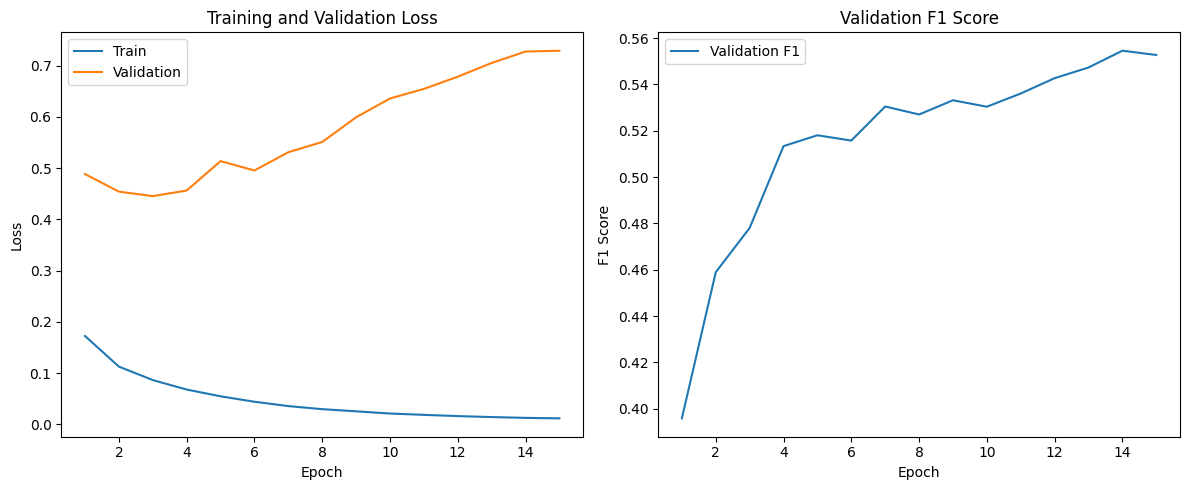

In [33]:
train_losses = [
    0.1723, 0.1126, 0.0863, 0.0678, 0.0546,
    0.0440, 0.0355, 0.0295, 0.0253, 0.0210,
    0.0184, 0.0160, 0.0141, 0.0125, 0.0116
]
plt.figure(figsize=(12, 5))

# Vẽ loss
plt.subplot(1, 2, 1)
# Chia train_losses theo số batch mỗi epoch trước khi vẽ
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Vẽ F1 score
plt.subplot(1, 2, 2)
plt.plot(range(1, len(val_f1s) + 1), val_f1s, label='Validation F1')
plt.title('Validation F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()

plt.tight_layout()
plt.savefig("training_curves.png")
plt.show()


In [34]:
print("Evaluating on test set...")
test_results = evaluate(model, test_loader, device, id2label)

print(f"Test Loss: {test_results['loss']:.4f}")
print(f"Test F1: {test_results['f1']:.4f}")
print(f"Test Precision: {test_results['precision']:.4f}")
print(f"Test Recall: {test_results['recall']:.4f}")
print("Test Classification Report:")
print(test_results['report'])

Evaluating on test set...
Test Loss: 0.7552
Test F1: 0.5668
Test Precision: 0.5405
Test Recall: 0.5957
Test Classification Report:
                     precision    recall  f1-score   support

bien_phap_chan_doan       0.52      0.57      0.54       308
 bien_phap_dieu_tri       0.43      0.45      0.44       632
   nguyen_nhan_benh       0.26      0.31      0.28       276
           ten_benh       0.66      0.72      0.69      1822
   trieu_chung_benh       0.45      0.52      0.48       712

          micro avg       0.54      0.60      0.57      3750
          macro avg       0.47      0.51      0.49      3750
       weighted avg       0.54      0.60      0.57      3750



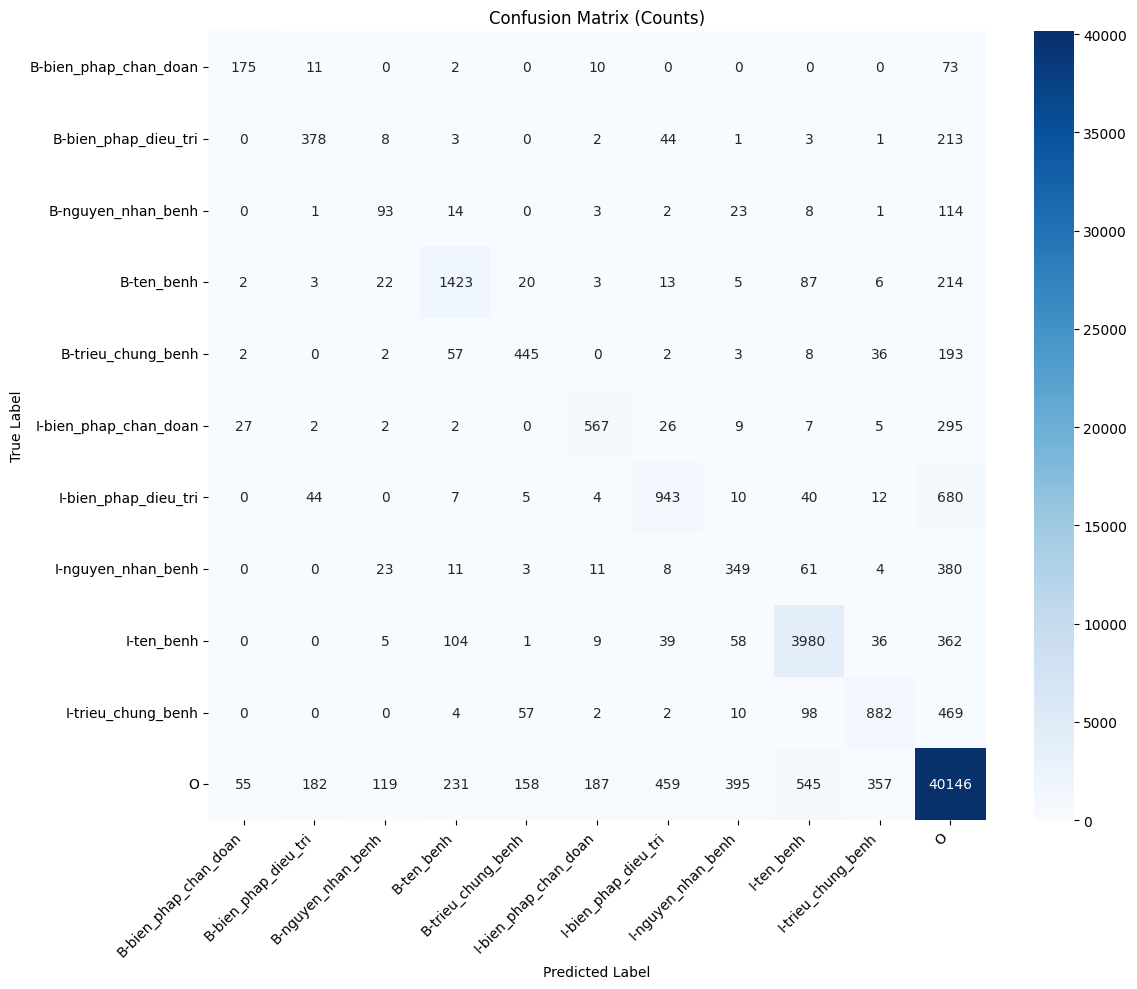

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import torch
import numpy as np

def plot_confusion_matrix_counts(model, data_loader, device, id2label):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            # Lưu ý: model trả dict, lấy logits
            preds = torch.argmax(outputs['logits'], dim=-1)

            mask = (labels != -100)
            all_preds.extend(preds[mask].cpu().numpy())
            all_labels.extend(labels[mask].cpu().numpy())

    class_names = [id2label[i] for i in range(len(id2label))]
    cm = confusion_matrix(all_labels, all_preds)  # Không normalize

    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix (Counts)')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# Usage
plot_confusion_matrix_counts(model, val_loader, device, id2label)


In [38]:
def predict_example(text: str):
    print(f"Input: {text}")
    predictions = predict_ner(text, model, tokenizer, id2label)
    
    print("\nPredictions:")
    for word, label in predictions:
        print(f"{word}: {label}")
    
    print("\n" + "="*50 + "\n")

# Ví dụ
examples = [   
    "Bệnh nhân bị viêm phổi cấp do vi khuẩn cần phải điều trị bằng Amoxicillin."
]

for example in examples:
    predict_example(example)

# Cell 14: Lưu mô hình và tokenizer
output_dir = "final_model"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Lưu mô hình
model_to_save = model.module if hasattr(model, 'module') else model
torch.save(model_to_save.state_dict(), os.path.join(output_dir, "pytorch_model.bin"))

# Lưu cấu hình
with open(os.path.join(output_dir, "config.json"), "w") as f:
    import json
    json.dump({"label2id": label2id, "id2label": id2label}, f)

# Lưu tokenizer
tokenizer.save_pretrained(output_dir)

print(f"Model saved to {output_dir}")

Input: Bệnh nhân bị viêm phổi cấp do vi khuẩn cần phải điều trị bằng Amoxicillin.

Predictions:
Bệnh: O
nhân: O
bị: O
viêm: B-ten_benh
phổi: I-ten_benh
cấp: O
do: O
vi: B-nguyen_nhan_benh
khuẩn: I-nguyen_nhan_benh
cần: O
phải: O
điều: O
trị: O
bằng: O
Amoxicillin.: B-bien_phap_dieu_tri


Model saved to final_model
